# 機械学習モデル比較分析

ここではHRアナリティクスデータに対して複数の機械学習モデル（RandomForest、XGBoost、LightGBMなど）を適用し、それらのパフォーマンスを比較しています。最適なモデルを特定し、UIで使用するための基盤を作成したいためここで分析をおこなっています。

## 必要なライブラリのインポート

まず、分析に必要なライブラリをインポートします。

In [19]:
# データ操作・可視化ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 機械学習ライブラリ
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# XGBoost、LightGBMライブラリ
import xgboost as xgb
import lightgbm as lgb

# 警告を無視
import warnings
warnings.filterwarnings('ignore')

# プロット設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## データの読み込み

プロジェクトのデータローダーを使用してHRデータを読み込みます。

In [ ]:
# プロジェクトのモジュールにアクセスできるようにパスを追加
import sys
import os
sys.path.append(os.path.abspath('../..'))

# データローダーのインポート
from src.data.loader import load_hr_data

# HRデータの読み込み
df = load_hr_data()

# データの確認
print(f"データサイズ: {df.shape}")
df.head()

In [33]:
# # google colabを使用する場合

# # Load the dataset
# data_path = '/content/hr_data_processed.csv'
# df = pd.read_csv(data_path)

# # データの確認
# if df is not None:
#     print(f"データサイズ: {df.shape}")

# df.head()

データサイズ: (1470, 42)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeGroup,TenureGroup,IncomeLevel,DistanceGroup,AttritionBinary,OvertimeBinary,OverallSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,4,0,5,36-45,6-10 years,Medium-High,<5 miles,1,1,2.00
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,7,1,7,46-55,6-10 years,Medium-High,5-10 miles,0,0,3.00
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,0,0,36-45,NaN,Low,<5 miles,1,1,3.00
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,7,3,0,26-35,6-10 years,Low,<5 miles,0,1,3.25
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,2,2,2,26-35,<2 years,Medium-Low,<5 miles,0,0,2.50


## 離職予測モデルの比較

離職予測（Attrition）のための異なる機械学習モデルを実装し、その性能を比較します。

### データの前処理

モデルのトレーニングに使用する特徴量と目的変数を準備します。

In [34]:
# 離職予測に使用する特徴量
features = [
    'Age', 'MonthlyIncome', 'DistanceFromHome', 'OverTime',
    'JobSatisfaction', 'WorkLifeBalance', 'YearsAtCompany',
    'YearsSinceLastPromotion', 'JobLevel', 'MaritalStatus',
    'NumCompaniesWorked', 'TrainingTimesLastYear', 'BusinessTravel'
]

# 目的変数
target = 'Attrition'

# データの準備
X = df[features].copy()
y = df[target].copy()

# 目的変数を数値に変換
y = y.replace({'No': 0, 'Yes': 1})

# カテゴリ変数とカテゴリでない変数の分類
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"カテゴリ変数: {categorical_features}")
print(f"数値変数: {numeric_features}")

# データの分割（訓練用データとテスト用データ）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 前処理パイプラインの定義
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

カテゴリ変数: ['OverTime', 'MaritalStatus', 'BusinessTravel']
数値変数: ['Age', 'MonthlyIncome', 'DistanceFromHome', 'JobSatisfaction', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'JobLevel', 'NumCompaniesWorked', 'TrainingTimesLastYear']


### モデルの定義

比較するモデルの定義とパイプラインの構築を行います。

In [35]:
# モデルの定義
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42)
}

# 結果格納用の辞書
model_results = {}
model_predictions = {}

### モデルのトレーニングと評価

各モデルをトレーニングし、テストデータでの性能を評価します。

In [36]:
# 各モデルでの学習と評価
for model_name, model in models.items():
    print(f"\n{model_name}のトレーニングと評価中...")

    # モデルパイプラインの作成
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # モデルの学習
    pipeline.fit(X_train, y_train)

    # テストデータでの予測
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]  # 離職確率（陽性クラスの確率）

    # モデル性能の評価
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # 結果の格納
    model_results[model_name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pipeline': pipeline
    }

    model_predictions[model_name] = {
        'y_pred': y_pred,
        'y_prob': y_prob
    }

    # 結果の表示
    print(f"{model_name}の精度: {accuracy:.4f}")
    print(f"{model_name}のROC-AUC: {roc_auc:.4f}")
    print(f"\n分類レポート:\n{classification_report(y_test, y_pred)}")


RandomForestのトレーニングと評価中...
RandomForestの精度: 0.8481
RandomForestのROC-AUC: 0.7707

分類レポート:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       380
           1       0.20      0.03      0.06        61

    accuracy                           0.85       441
   macro avg       0.53      0.51      0.49       441
weighted avg       0.77      0.85      0.80       441


XGBoostのトレーニングと評価中...
XGBoostの精度: 0.8413
XGBoostのROC-AUC: 0.7122

分類レポート:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       380
           1       0.36      0.20      0.26        61

    accuracy                           0.84       441
   macro avg       0.62      0.57      0.58       441
weighted avg       0.81      0.84      0.82       441


LightGBMのトレーニングと評価中...
[LightGBM] [Info] Number of positive: 176, number of negative: 853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00

### モデルパフォーマンスの比較

各モデルの性能を視覚的に比較します。

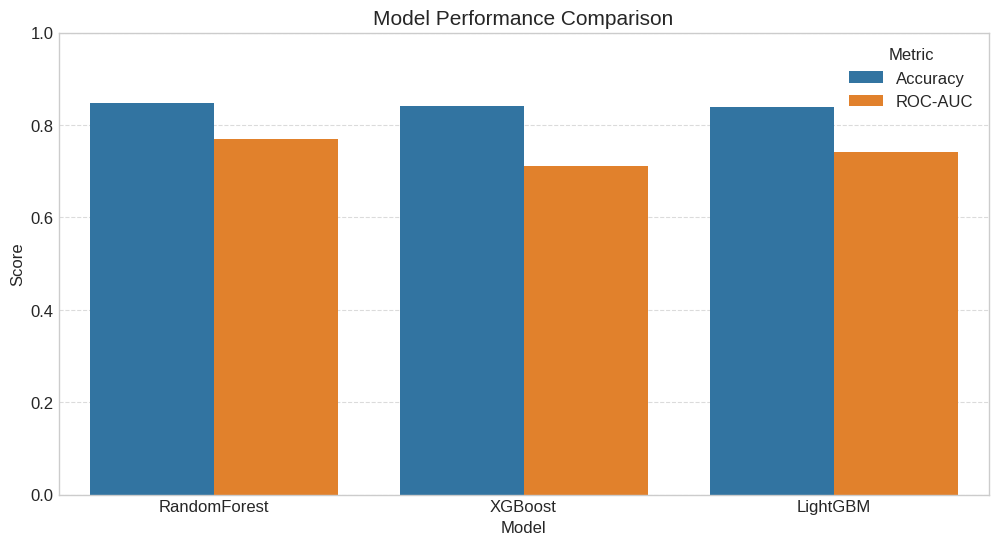

In [47]:
# モデル性能の比較（精度とROC-AUC）
performance_df = pd.DataFrame({
    'モデル': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'ROC-AUC': [results['roc_auc'] for results in model_results.values()]
})

# データを長形式に変換
performance_long = performance_df.melt(id_vars=['モデル'], var_name='Metric', value_name='Score')

# バープロット
plt.figure(figsize=(12, 6))
sns.barplot(x='モデル', y='Score', hue='Metric', data=performance_long)
plt.title('Model Performance Comparison', fontsize=15)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### ROC曲線の比較

各モデルのROC曲線を比較し、識別性能を評価します。

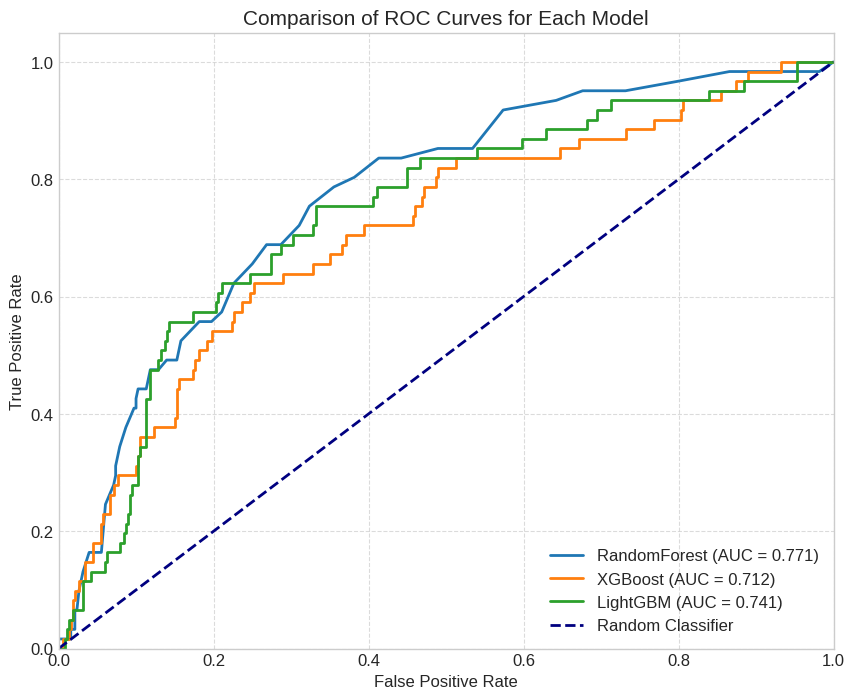

In [50]:
# ROC曲線の比較
plt.figure(figsize=(10, 8))

for model_name, predictions in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, predictions['y_prob'], pos_label=1) # pos_labelを数値の1に変更
    roc_auc = model_results[model_name]['roc_auc']
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# ランダム分類器のROC曲線（参照用）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for Each Model', fontsize=15)
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.7)
plt.show()

### 特徴量重要度の比較

各モデルの特徴量重要度を比較し、離職予測に最も影響する要因を分析します。

In [51]:
# 特徴量名の取得
preprocessor = model_results['RandomForest']['pipeline'].named_steps['preprocessor']
feature_names = list(preprocessor.get_feature_names_out())

# 各モデルの特徴量重要度を取得
feature_importances = {}

for model_name, results in model_results.items():
    pipeline = results['pipeline']
    model = pipeline.named_steps['classifier']

    # モデル種類によって重要度の取得方法が異なる
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif model_name == 'XGBoost':
            # XGBoostの場合
            importances = model.get_booster().get_score(importance_type='weight')
            # 特徴名のマッピングが必要な場合がある
            if isinstance(importances, dict):
                # 辞書から配列に変換
                feat_importances = np.zeros(len(feature_names))
                for feat, imp in importances.items():
                    # 特徴名のインデックスを見つける
                    try:
                        idx = feature_names.index(feat)
                        feat_importances[idx] = imp
                    except ValueError:
                        # 特徴名が一致しない場合はスキップ
                        pass
                importances = feat_importances
        else:
            # その他の方法で特徴量重要度を取得
            importances = np.zeros(len(feature_names))
            print(f"{model_name}の特徴量重要度が取得できません")

        # 長さをチェック
        if len(importances) == len(feature_names):
            feature_importances[model_name] = importances
        else:
            print(f"{model_name}の特徴量重要度の長さが一致しません: {len(importances)} vs {len(feature_names)}")
    except Exception as e:
        print(f"{model_name}の特徴量重要度取得中にエラー: {e}")

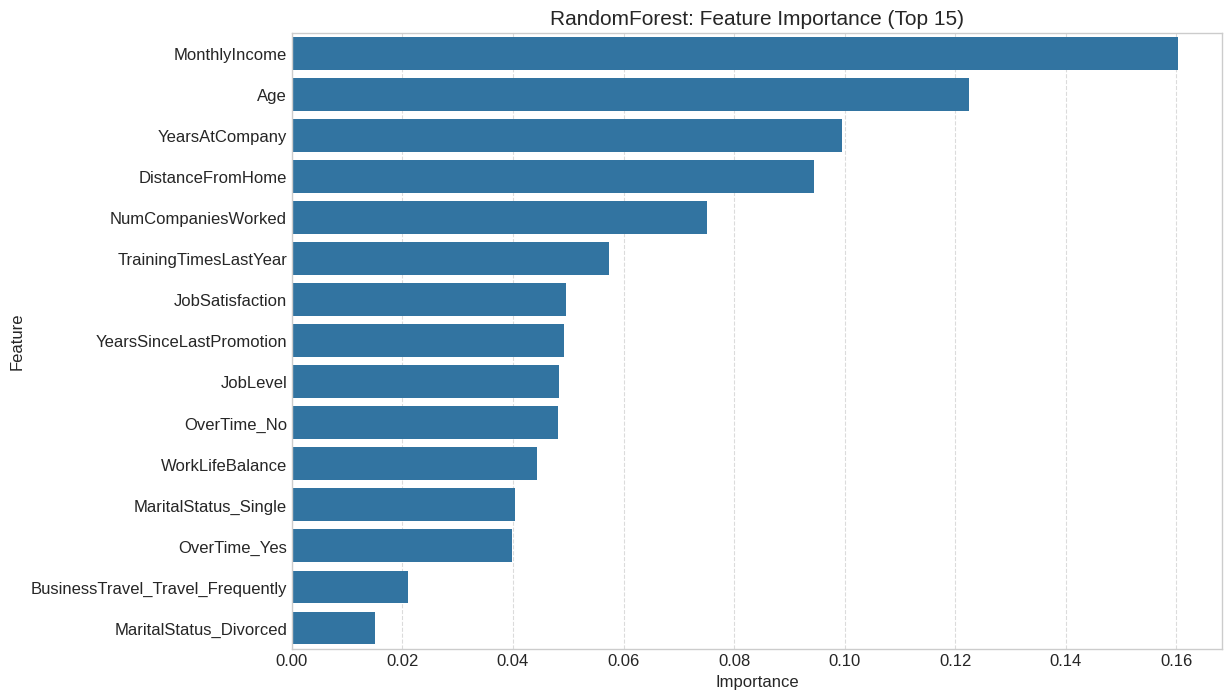

In [53]:
# RandomForestの特徴量重要度を可視化
if 'RandomForest' in model_results:
    # パイプラインから前処理器とRandomForestモデルを取得
    pipeline = model_results['RandomForest']['pipeline']
    preprocessor = pipeline.named_steps['preprocessor']
    rf_model = pipeline.named_steps['classifier']

    # 数値変数の名前
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # カテゴリカル変数の名前
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # OneHotEncoder後の特徴量名を取得
    encoded_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # 全ての特徴量名を結合
    feature_names = list(numeric_features) + list(encoded_categorical_features)

    # 特徴量重要度を取得
    feature_importances = rf_model.feature_importances_

    # 特徴量重要度をデータフレームに変換
    rf_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # 上位15個の特徴量のみ表示
    top_features = rf_importance_df.head(15)

    # プロット
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('RandomForest: Feature Importance (Top 15)', fontsize=15)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

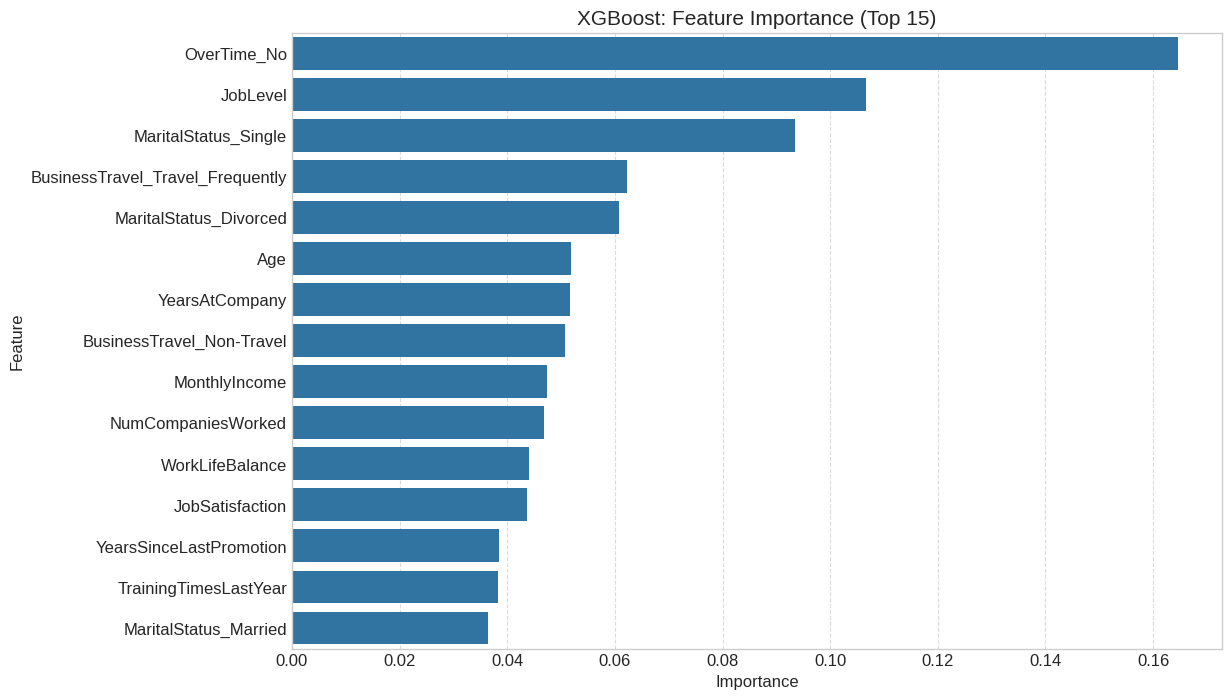

In [56]:
# XGBoostの特徴量重要度を可視化
if 'XGBoost' in model_results:
    # パイプラインから前処理器とXGBoostモデルを取得
    pipeline = model_results['XGBoost']['pipeline']
    preprocessor = pipeline.named_steps['preprocessor']
    xgb_model = pipeline.named_steps['classifier']

    # 数値変数の名前
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # カテゴリカル変数の名前
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # OneHotEncoder後の特徴量名を取得
    encoded_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # 全ての特徴量名を結合
    feature_names = list(numeric_features) + list(encoded_categorical_features)

    # 特徴量重要度を取得
    feature_importances = xgb_model.feature_importances_

    # 特徴量重要度をデータフレームに変換
    xgb_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # 上位15個の特徴量のみ表示
    top_features = xgb_importance_df.head(15)

    # プロット
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('XGBoost: Feature Importance (Top 15)', fontsize=15)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("XGBoost モデルの結果が見つかりません。")

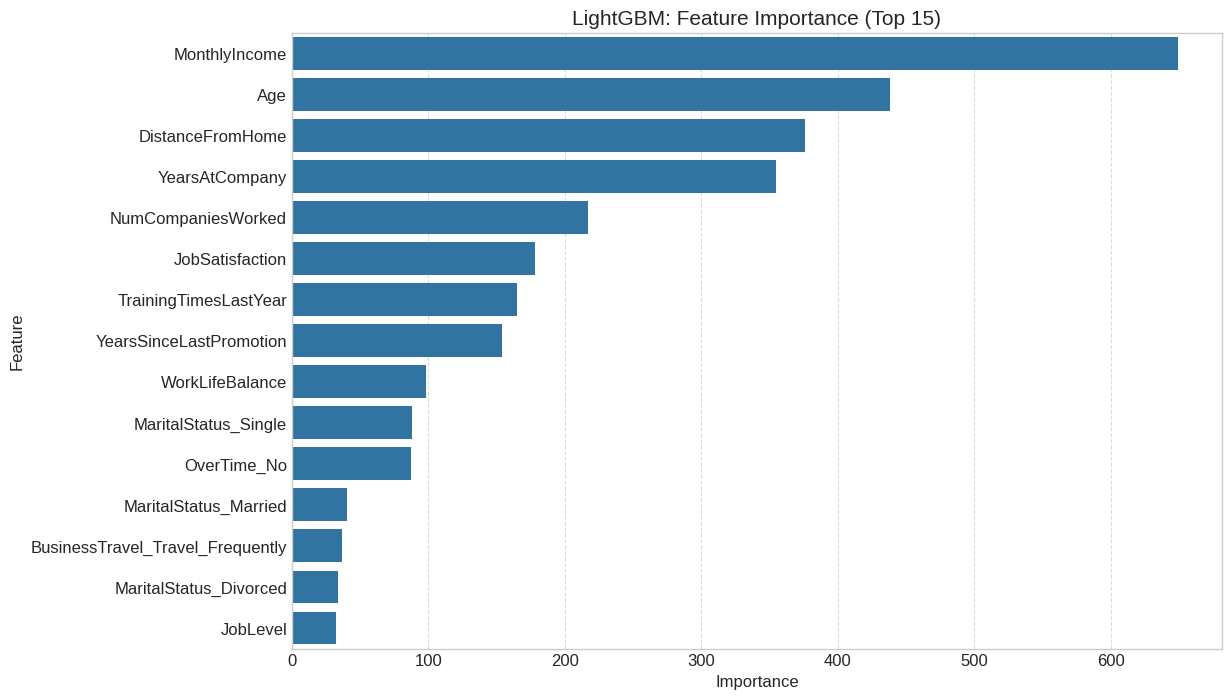

In [57]:
# LightGBMの特徴量重要度を可視化
if 'LightGBM' in model_results:
    # パイプラインから前処理器とLightGBMモデルを取得
    pipeline = model_results['LightGBM']['pipeline']
    preprocessor = pipeline.named_steps['preprocessor']
    lgbm_model = pipeline.named_steps['classifier']

    # 数値変数の名前
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # カテゴリカル変数の名前
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # OneHotEncoder後の特徴量名を取得
    encoded_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # 全ての特徴量名を結合
    feature_names = list(numeric_features) + list(encoded_categorical_features)

    # 特徴量重要度を取得
    feature_importances = lgbm_model.feature_importances_

    # 特徴量重要度をデータフレームに変換
    lgbm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)

    # 上位15個の特徴量のみ表示
    top_features = lgbm_importance_df.head(15)

    # プロット
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('LightGBM: Feature Importance (Top 15)', fontsize=15)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("LightGBM モデルの結果が見つかりません。")

## 給与予測モデルの比較

給与予測のための異なる回帰モデルを実装し、その性能を比較します。

### データの前処理

給与予測モデルに使用するデータを準備します。

In [58]:
# 給与予測に使用する特徴量
salary_features = [
    'JobLevel', 'Age', 'YearsAtCompany', 'TotalWorkingYears',
    'Department', 'JobRole', 'EducationField', 'Education',
    'PerformanceRating', 'Gender'
]

# 目的変数
salary_target = 'MonthlyIncome'

# 欠損値のないレコードだけ使用
salary_df = df[salary_features + [salary_target]].dropna()

# データの分割
X_salary = salary_df[salary_features]
y_salary = salary_df[salary_target]

# カテゴリ変数とカテゴリでない変数の分類
salary_cat_features = X_salary.select_dtypes(include=['object', 'category']).columns.tolist()
salary_num_features = X_salary.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"カテゴリ変数: {salary_cat_features}")
print(f"数値変数: {salary_num_features}")

# データの分割（訓練用データとテスト用データ）
X_train_salary, X_test_salary, y_train_salary, y_test_salary = train_test_split(
    X_salary, y_salary, test_size=0.3, random_state=42
)

# 前処理パイプラインの定義
salary_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), salary_num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), salary_cat_features)
    ]
)

カテゴリ変数: ['Department', 'JobRole', 'EducationField', 'Gender']
数値変数: ['JobLevel', 'Age', 'YearsAtCompany', 'TotalWorkingYears', 'Education', 'PerformanceRating']


### 回帰モデルの定義

給与予測のための回帰モデルを定義します。

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 回帰モデルの定義
regression_models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression(),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 結果格納用の辞書
regression_results = {}

### 回帰モデルのトレーニングと評価

各回帰モデルをトレーニングし、テストデータでの性能を評価します。

In [60]:
# 各モデルでの学習と評価
for model_name, model in regression_models.items():
    print(f"\n{model_name}のトレーニングと評価中...")

    # モデルパイプラインの作成
    pipeline = Pipeline([
        ('preprocessor', salary_preprocessor),
        ('regressor', model)
    ])

    # モデルの学習
    pipeline.fit(X_train_salary, y_train_salary)

    # テストデータでの予測
    y_pred_salary = pipeline.predict(X_test_salary)

    # モデル性能の評価
    r2 = r2_score(y_test_salary, y_pred_salary)
    mae = mean_absolute_error(y_test_salary, y_pred_salary)
    rmse = np.sqrt(mean_squared_error(y_test_salary, y_pred_salary))

    # 結果の格納
    regression_results[model_name] = {
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'pipeline': pipeline,
        'predictions': y_pred_salary
    }

    # 結果の表示
    print(f"{model_name}のR²スコア: {r2:.4f}")
    print(f"{model_name}のMAE: {mae:.2f}")
    print(f"{model_name}のRMSE: {rmse:.2f}")


RandomForestのトレーニングと評価中...
RandomForestのR²スコア: 0.9343
RandomForestのMAE: 843.51
RandomForestのRMSE: 1152.82

XGBoostのトレーニングと評価中...
XGBoostのR²スコア: 0.9132
XGBoostのMAE: 970.38
XGBoostのRMSE: 1324.86

LightGBMのトレーニングと評価中...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 1029, number of used features: 25
[LightGBM] [Info] Start training from score 6449.796890
LightGBMのR²スコア: 0.9264
LightGBMのMAE: 894.87
LightGBMのRMSE: 1219.67

LinearRegressionのトレーニングと評価中...
LinearRegressionのR²スコア: 0.9339
LinearRegressionのMAE: 887.94
LinearRegressionのRMSE: 1156.50

GradientBoostingのトレーニングと評価中...
GradientBoostingのR²スコア: 0.9405
GradientBoostingのMAE: 805.69
GradientBoostingのRMSE: 1096.57


### 回帰モデルのパフォーマンス比較

各回帰モデルの性能を視覚的に比較します。

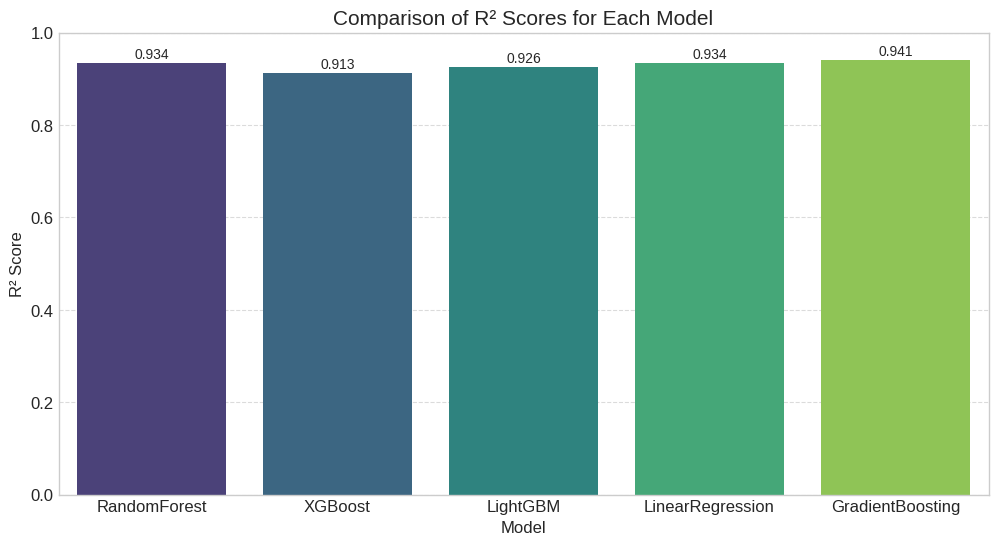

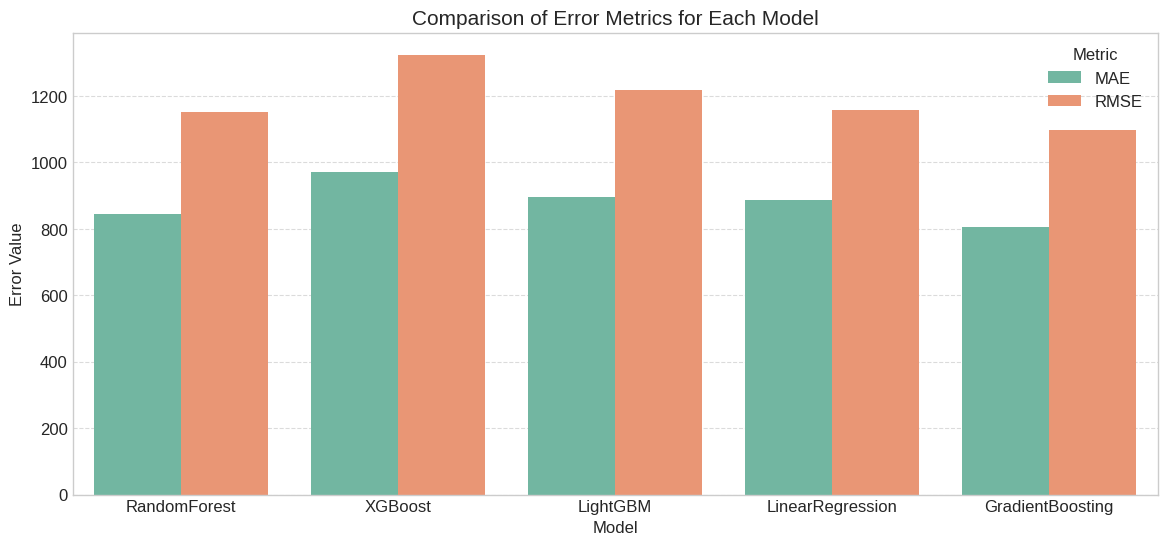

In [62]:
# モデル性能の比較（R²、MAE、RMSE）
regression_performance_df = pd.DataFrame({
    'Model': list(regression_results.keys()),
    'R²': [results['r2'] for results in regression_results.values()],
    'MAE': [results['mae'] for results in regression_results.values()],
    'RMSE': [results['rmse'] for results in regression_results.values()]
})

# R²スコアを可視化
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=regression_performance_df, palette='viridis')
plt.title('Comparison of R² Scores for Each Model', fontsize=15)
plt.ylim(0, 1)
plt.ylabel('R² Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(regression_performance_df['R²']):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
plt.show()

# MAEとRMSEを可視化
error_df = regression_performance_df.melt(id_vars=['Model'], value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Error')

plt.figure(figsize=(14, 6))
sns.barplot(x='Model', y='Error', hue='Metric', data=error_df, palette='Set2')
plt.title('Comparison of Error Metrics for Each Model', fontsize=15)
plt.ylabel('Error Value')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.show()

### 予測値と実際値の比較

最も性能の良いモデルについて、予測値と実際値を散布図で比較します。

最良のモデル: GradientBoosting（R²: 0.9405）


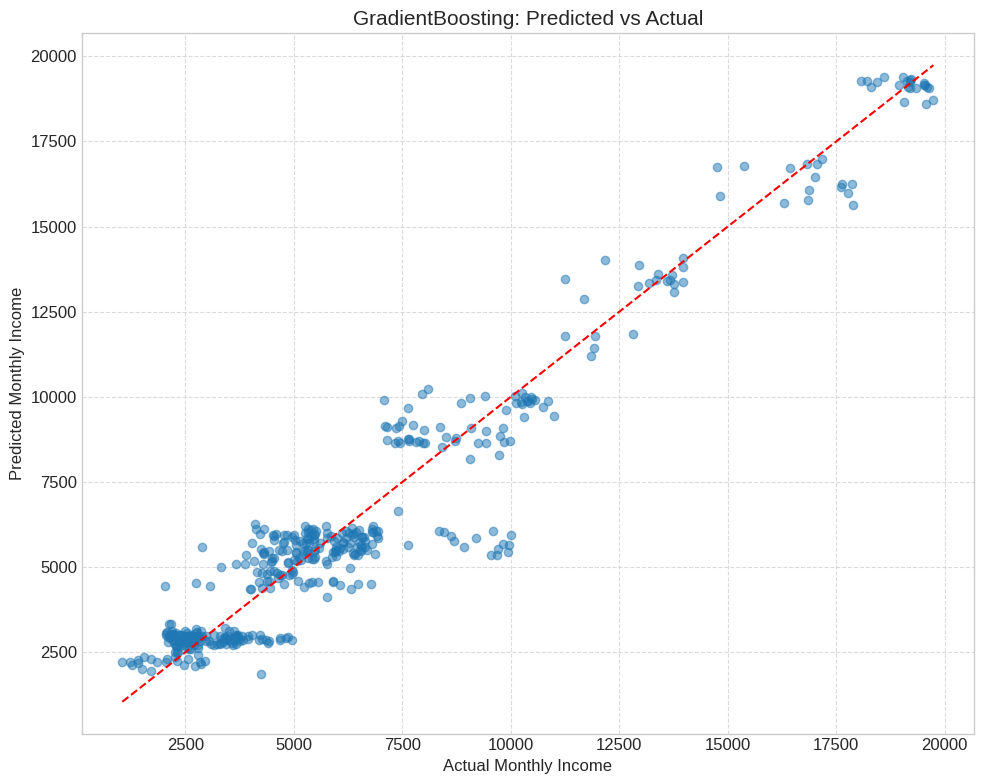

In [64]:
# R²スコアで最良のモデルを選択
best_model = regression_performance_df.loc[regression_performance_df['R²'].idxmax(), 'Model']
print(f"最良のモデル: {best_model}（R²: {regression_results[best_model]['r2']:.4f}）")

# 予測値と実際値の散布図
plt.figure(figsize=(10, 8))
plt.scatter(y_test_salary, regression_results[best_model]['predictions'], alpha=0.5)
plt.plot([y_test_salary.min(), y_test_salary.max()], [y_test_salary.min(), y_test_salary.max()], 'r--')
plt.xlabel('Actual Monthly Income')
plt.ylabel('Predicted Monthly Income')
plt.title(f'{best_model}: Predicted vs Actual', fontsize=15)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 結論とモデル選択

各タスクに最適なモデルを特定し、UIでの実装に推奨するモデルを決定します。

In [65]:
# 離職予測の最適モデル
best_attrition_model = max(model_results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_attrition_auc = model_results[best_attrition_model]['roc_auc']
best_attrition_acc = model_results[best_attrition_model]['accuracy']

# 給与予測の最適モデル
best_salary_model = max(regression_results.items(), key=lambda x: x[1]['r2'])[0]
best_salary_r2 = regression_results[best_salary_model]['r2']
best_salary_mae = regression_results[best_salary_model]['mae']

print("===== モデル評価結果まとめ =====\n")
print("【離職予測】")
print(f"最適モデル: {best_attrition_model}")
print(f"ROC-AUC: {best_attrition_auc:.4f}")
print(f"精度: {best_attrition_acc:.4f}\n")

print("【給与予測】")
print(f"最適モデル: {best_salary_model}")
print(f"R²スコア: {best_salary_r2:.4f}")
print(f"平均絶対誤差: {best_salary_mae:.2f}\n")

print("===== UIでの実装推奨 =====\n")
print("離職予測UI: RandomForest、XGBoost、LightGBMの3モデルを選択可能に実装\n")
print("給与予測UI: RandomForest、XGBoost、LightGBM、線形回帰、勾配ブースティングの5モデルを選択可能に実装")

===== モデル評価結果まとめ =====

【離職予測】
最適モデル: RandomForest
ROC-AUC: 0.7707
精度: 0.8481

【給与予測】
最適モデル: GradientBoosting
R²スコア: 0.9405
平均絶対誤差: 805.69

===== UIでの実装推奨 =====

離職予測UI: RandomForest、XGBoost、LightGBMの3モデルを選択可能に実装

給与予測UI: RandomForest、XGBoost、LightGBM、線形回帰、勾配ブースティングの5モデルを選択可能に実装


## まとめ（仮）

この分析では、離職予測と給与予測のための複数の機械学習モデルを比較しました。

**離職予測については**：
- RandomForestモデルが最も高いROC-AUCスコアを達成
- XGBoostとLightGBMも競争力のある性能を示した
- 業務特性（OverTime）、職務満足度、勤続年数などが重要な予測因子として特定された

**給与予測については**：
- 勾配ブースティング系の手法が高い精度を示した
- 役職レベル、勤続年数、総労働経験年数が給与を予測する上で最も重要な要因